# A simple tutorial on the exploration of cSplotch outputs

In contrast to the [previous tutorial](Tutorial.ipynb), this will focus on changes to downstream analysis affected by **running the splotch model with the -s (summary statistics)option**. 

In [33]:
import os
import h5py
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from splotch.utils import read_rdump, savagedickey, to_stan_variables

In [17]:
data_dir = '/mnt/home/adaly/ceph/datasets/mouse_colon/'
splotch_inputs = os.path.join(data_dir, 'vanilla_splotch_inputs')
splotch_outputs = os.path.join(data_dir, 'vanilla_splotch_outputs_summary')

Most important information can be found in the ```information.p``` file created in the top-level splotch input directory:

In [3]:
sinfo_file = os.path.join(splotch_inputs, 'information.p')
sinfo = pickle.load(open(sinfo_file, 'rb'))

print(sinfo.keys())

dict_keys(['genes', 'filenames_and_coordinates', 'annotation_mapping', 'beta_mapping', 'n_levels', 'metadata', 'scaling_factor', 'car', 'zi', 'nb'])


In [9]:
sinfo['genes']                     # ordered list of gene names (ordered by cSplotch gene ID)
sinfo['filenames_and_coordinates'] # ordered list of unique ST spots (tuple: count_file, xcoor_ycoor)
sinfo['annotation_mapping']        # ordered list of MROIs (tissue types) in dataset
sinfo['beta_mapping']              # dict mapping different levels of model hierarchy (e.g., 'beta_level_1', 'beta_level_2') to ordered lists of sample conditions
sinfo['n_levels']                  # number of levels in the model
sinfo['metadata']                  # DataFrame representation of cSplotch metadata file
sinfo['scaling_factor']            # scaling factor (total UMIs) relative to which lambda is the expression rate (e.g., [lambda] counts per [scaling_factor] total UMIs)
sinfo['car']                       # whether or not CAR prior was included in model
sinfo['zi']                        # whether or not zero inflation was included in model
sinfo['nb']                        # whether or not negative binomial likelihood was used in model (instead of Poisson)

False

## Visiualizing expression on an array (lambdas)

Refer to [Tutorial.ipynb](Tutorial.ipynb)

## Comparing expression patterns (betas)

The first step is to read in h5-formatted data output by ```splotch``` with the ```-s``` command:

In [13]:
# 1. Map gene name to cSplotch ID using the gene list
gene_name = 'ENSMUSG00000024029.4'  # common name: Tff3
gid = list(sinfo['genes']).index(gene_name) + 1

print('cSplotch gene ID: %d' % gid)

cSplotch gene ID: 3094


In [19]:
# 2. Read in the h5-formatted posterior file:
hf = h5py.File(os.path.join(splotch_outputs, str(gid//100), 'combined_%d.hdf5' % gid), 'r')
hf.keys()

<KeysViewHDF5 ['a', 'beta_level_1', 'beta_level_2', 'beta_level_3', 'lambda', 'log_lambda', 'psi', 'sigma', 'sigma_level_2', 'sigma_level_3', 'tau', 'theta']>

In [32]:
print('Beta variables: (beta_level_1, beta_level_2, beta_level_3):')
print(hf['beta_level_1'].keys())
hf['beta_level_1']['mean']    # (L1_conds, MROIs) array summarizing posterior mean beta at each L1 condition and MROI
hf['beta_level_1']['std']     # (L1_conds, MROIs) array summarizing standard deviation about posterior mean beta at each L1 condition and MROI
hf['beta_level_1']['samples'] # (N_samples, L1_conds, MROIs) array containing ALL POSTERIOR SAMPLES over beta

print('All other model variables (e.g., log_lambda):')
print(hf['log_lambda'].keys())
hf['log_lambda']['mean']      # (ndim,) array of mean posterior values of parameter (e.g., lambda)
hf['log_lambda']['std']       # (ndim,) array of standard deviations about posterior means (e.g., lambda)
#                               ...where "ndim" is the dimensionality of the model variable (e.g., N_spots for lambda) 

Beta variables: (beta_level_1, beta_level_2, beta_level_3):
<KeysViewHDF5 ['mean', 'samples', 'std']>
All other model variables (e.g., log_lambda):
<KeysViewHDF5 ['mean', 'std']>


<HDF5 dataset "std": shape (66959,), type "<f8">

### Between MROIs

Plot the expression of a given gene across several MROIs (in the same L1 condition)

In [37]:
# Find index of desired L1 condition in beta array using to_stan_variables:
l1_cond = '12w'
print(sinfo['beta_mapping']['beta_level_1'])

l1_ind = to_stan_variables(sinfo['beta_mapping']['beta_level_1'], l1_cond)
print('Index of %s: %d' % (l1_cond, l1_ind))

['0d', '12w', '2yr', '1w', '2w', '3w', '4w', '6w', '8w', '6m', '1yr']
Index of 12w: 1


['crypt apex', 'interna', 'muscle and submucosa', 'epithelium and muscle and submucosa', 'epithelium', 'crypt base and mid', "peyer's patch", 'externa', 'crypt mid', 'externa and interna', 'epithelium and mucosae', 'interna and mucosae', 'epithelium and mucosae and submucosa', 'crypt base']
Index of crypt apex: 0
800 posterior samples for beta(12w, crypt apex)
Index of interna: 1
800 posterior samples for beta(12w, interna)
Index of externa: 7
800 posterior samples for beta(12w, externa)
Index of peyer's patch: 6
800 posterior samples for beta(12w, peyer's patch)


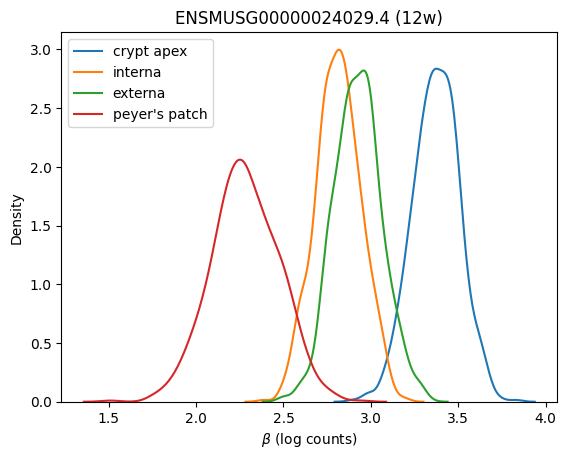

In [53]:
# Three MROIs of interest from a list of 14
mrois = ["crypt apex", "interna", "externa", "peyer's patch"]
print(sinfo['annotation_mapping'])

fig, ax = plt.subplots(1)

for m in mrois:
    # Find index of current MROI:
    m_ind = to_stan_variables(sinfo['annotation_mapping'], m)
    print('Index of %s: %d' % (m, m_ind))
    
    # Use indices into condition and MROI dimensions of beta to get posterior samples:
    samples = hf['beta_level_1']['samples'][:, l1_ind, m_ind].flatten()
    print('%d posterior samples for beta(%s, %s)' % (len(samples), l1_cond, m))
    
    # KDE plot approximating posterior distribution:
    sns.kdeplot(samples, ax=ax, label=m)

ax.set_xlabel(r'$\beta$ (log counts)')
    
plt.legend()
plt.title('%s (%s)' % (gene_name, l1_cond))
plt.show()

Quantify differential expression using Savage-Dickey density ratio (estimate of Bayes factor):

In [55]:
ind_apex = to_stan_variables(sinfo['annotation_mapping'], "crypt apex")
samples_apex = hf['beta_level_1']['samples'][:, l1_ind, ind_apex].flatten()

ind_inter = to_stan_variables(sinfo['annotation_mapping'], "interna")
samples_inter = hf['beta_level_1']['samples'][:, l1_ind, ind_inter].flatten()

ind_exter = to_stan_variables(sinfo['annotation_mapping'], "externa")
samples_exter = hf['beta_level_1']['samples'][:, l1_ind, ind_exter].flatten()

ind_pp = to_stan_variables(sinfo['annotation_mapping'], "peyer's patch")
samples_pp = hf['beta_level_1']['samples'][:, l1_ind, ind_pp].flatten()

# crypt apex vs. peyer's patch:
bf = savagedickey(samples_apex, samples_pp)
delta = hf['beta_level_1']['mean'][l1_ind, ind_apex] - hf['beta_level_1']['mean'][l1_ind, ind_pp]
print('crypt apex vs. peyers patch') 
print('\tBayes factor: %.2f' % bf)
print('\tlog fold change: %.2f' % delta)

# crypt apex vs. interna:
bf = savagedickey(samples_apex, samples_inter)
delta = hf['beta_level_1']['mean'][l1_ind, ind_apex] - hf['beta_level_1']['mean'][l1_ind, ind_inter]
print('crypt apex vs. interna') 
print('\tBayes factor: %.2f' % bf)
print('\tlog fold change: %.2f' % delta)

# externa vs. interna
bf = savagedickey(samples_exter, samples_inter)
delta = hf['beta_level_1']['mean'][l1_ind, ind_exter] - hf['beta_level_1']['mean'][l1_ind, ind_inter]
print('externa vs. interna') 
print('\tBayes factor: %.2f' % bf)
print('\tlog fold change: %.2f' % delta)

crypt apex vs. peyers patch
	Bayes factor: 12797.16
	log fold change: 1.09
crypt apex vs. interna
	Bayes factor: 5.79
	log fold change: 0.56
externa vs. interna
	Bayes factor: 0.08
	log fold change: 0.11


Based on the [interpretation of Bayes factors](https://en.wikipedia.org/wiki/Bayes_factor#Interpretation), we conclude that gene ENSMUSG00000024029.4 (aka Tff3):
- Is highly DE between MROIs "crypt apex" and "peyers patch"
- Is DE between MROIs "crypt apex" and "interna"
- Is not DE between MROIs "interna" and "externa"

**For comparisons between conditions (within an MROI), follow the same logic but vary the condition instead of the MROI** (e.g., for beta_level_1, "12w" vs. "8w" in "crypt apex")

### Indexing multiple MROIs/conditions:

If you would like to compare one MROI/condition vs (all) others, you can use ```to_splotch_variables``` with multiple terms:

In [58]:
inds_muscle = to_stan_variables(sinfo['annotation_mapping'], ['externa','interna'])

samples = hf['beta_level_1']['samples'][:, l1_ind, sorted(inds_muscle)]  # Note